In [15]:
from argparse import Namespace
from itertools import count
from typing import Any, Dict, Optional
import json
import main
import numpy as np
from neat.activations import ActivationFunctionSet
from neat.aggregations import AggregationFunctionSet
from neat.genes import DefaultConnectionGene, DefaultNodeGene
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    generate_one_config_from_var_dict,
    get_bound_values,
    get_default_hyperparameters_as_array,
    get_var_name,
    get_var_type,
)
from spotPython.hyperparameters.values import get_var_name, get_var_type, get_bound_values, assign_values, generate_one_config_from_var_dict
from spotPython.spot import spot
from spotPython.utils.eda import gen_design_table
from spot_hyper_dict import SpotHyperDict


# dummy classes


In [16]:
class DummyGenomeConfig:
    def __init__(self):
        self.node_indexer = count(1)

    def get_new_node_key(self, node_dict):
        return next(self.node_indexer)

    def check_structural_mutation_surer(self):
        if self.structural_mutation_surer == 'true':
            return True
        elif self.structural_mutation_surer == 'false':
            return False
        elif self.structural_mutation_surer == 'default':
            return self.single_structural_mutation
        else:
            error_string = f"Invalid structural_mutation_surer {self.structural_mutation_surer!r}"
            raise RuntimeError(error_string)

class DummyModel(ActivationFunctionSet):
    def __init__(self):
        pass

    def __call__(self, name):
        return name


# naive objective functions

In [17]:
def mbf_objective(config: Namespace, n_runs: int = 20, verbose: int = 0):
    epoch_callback = None  # lambda fitness, evals: callback(trial, fitness,evals)
    fitness = 0.0
    mins, maxs, means, sizes_nodes, sizes_connections, all_fitnesses = [], [], [], [], [], []
    for i in range(n_runs):
        iter_fitness, maxs_curr, means_curr, mins_curr, net_size_nodes, net_size_connections, all_fitness = main.main(
            callback=epoch_callback, plot=False, config_in=config, verbose=verbose)
        fitness += iter_fitness
        mins.append(mins_curr)
        maxs.append(maxs_curr)
        means.append(means_curr)
        sizes_connections.append(net_size_connections)
        sizes_nodes.append(net_size_nodes)
        all_fitnesses.append(all_fitness)

    fitness_avg = fitness / n_runs

    # save_trial(trial._trial_id, config, maxs, mins, means, sizes_nodes, sizes_connections, all_fitnesses, study_name)
    return fitness_avg

def objective(X: np.ndarray, fun_control: Optional[Dict] = None):
    config = Namespace()
    config.genome_config = DummyGenomeConfig()
    config.POPULATION_SIZE = 50
    config.OFFSPRING_SIZE = 10  
    config.NUM_EVALS = 200
    config.NUM_GENERATIONS = 100  

    # These are normally provided in neat's config file
    config.genome_config.activation_default = "sigmoid"
    config.genome_config.activation_mutate_rate = 0.0
    config.genome_config.activation_options = "sigmoid"
    # node aggregation options
    config.genome_config.aggregation_default = "sum"
    config.genome_config.aggregation_mutate_rate = 0.0
    config.genome_config.aggregation_options = "sum"
    # node bias options
    config.genome_config.bias_init_mean = 0.0
    config.genome_config.bias_init_stdev = 1.0
    config.genome_config.bias_max_value = 30.0
    config.genome_config.bias_min_value = -30.0
    config.genome_config.bias_mutate_rate = 0.7
    config.genome_config.compatibility_disjoint_coefficient = 1.0
    config.genome_config.compatibility_weight_coefficient = 0.5
    config.genome_config.enabled_default = True
    config.genome_config.enabled_mutate_rate = 0.01
    config.genome_config.feed_forward = True
    config.genome_config.initial_connection = "full_direct"
    config.genome_config.num_hidden = 1
    config.genome_config.num_inputs = 4
    config.genome_config.num_outputs = 1
    config.genome_config.response_init_mean = 1.0
    config.genome_config.response_init_stdev = 0.0
    config.genome_config.response_max_value = 30.0
    config.genome_config.response_min_value = -30.0
    config.genome_config.response_mutate_power = 0.0
    config.genome_config.response_mutate_rate = 0.0
    config.genome_config.response_replace_rate = 0.0
    config.genome_config.weight_init_mean = 0.0
    config.genome_config.weight_init_stdev = 1.0
    config.genome_config.weight_max_value = 30
    config.genome_config.weight_min_value = -30
    config.genome_config.weight_mutate_power = 0.5
    config.genome_config.weight_mutate_rate = 0.8
    config.genome_config.weight_replace_rate = 0.1

    # these are needed besides the params that come from the file
    config.genome_config.output_keys = [i for i in range(config.genome_config.num_outputs)]
    config.genome_config.input_keys = [-i - 1 for i in range(config.genome_config.num_inputs)]
    config.genome_config.node_gene_type = DefaultNodeGene
    config.genome_config.connection_gene_type = DefaultConnectionGene
    config.genome_config.bias_init_type = "gaussian"
    config.genome_config.response_init_type = "gaussian"
    config.genome_config.weight_init_type = "gaussian"
    config.genome_config.activation_defs = ActivationFunctionSet()
    config.genome_config.aggregation_function_defs = AggregationFunctionSet()
    config.genome_config.aggregation_defs = config.genome_config.aggregation_function_defs
    config.genome_config.single_structural_mutation = False
    config.genome_config.enabled_rate_to_false_add = 0.0
    config.genome_config.enabled_rate_to_true_add = 0.0
    config.genome_config.structural_mutation_surer = 'default'

    y = np.empty((0, 1))
    var_dict = assign_values(X, fun_control["var_name"])
    for current_config in generate_one_config_from_var_dict(var_dict, fun_control):
        # config.genome_config.bias_mutate_power = current_config["bias_mutate_power"]
        # config.genome_config.bias_replace_rate = current_config["bias_replace_rate"]
        # config.genome_config.conn_add_prob = current_config["conn_add_prob"]
        # config.genome_config.conn_delete_prob = current_config["conn_delete_prob"]
        # config.genome_config.node_add_prob = current_config["node_add_prob"]
        # config.genome_config.node_delete_prob = current_config["node_delete_prob"]
        # config.genome_config.activation_default = current_config["activation_default"]
        # same thing but shorter
         # Update the configuration parameters
        for param_name, param_value in current_config.items():
            setattr(config.genome_config, param_name, param_value)


        fitness = -mbf_objective(config, n_runs=20, verbose=0)
        y = np.append(y, fitness)
    return y

# fun_control

In [18]:
# # fun_control is a dictionary that contains the information about the tuning
# # it could've been initialized with spot as :
# from spotPython.utils.init import fun_control_init
# from spotPython.utils.file import get_spot_tensorboard_path
# import os
# from spotPython.utils.file import get_experiment_name
# experiment_name = get_experiment_name(prefix=PREFIX)
# fun_control = fun_control_init(
#     spot_tensorboard_path=get_spot_tensorboard_path(experiment_name),
#     TENSORBOARD_CLEAN=True)
# print(experiment_name)

# however it's just a dictionary in the end, so you can also just create it yourself
fun_control = {}
# then we need to add the hyperparameters' specifications to the fun_control dictionary
# to make our lives easier, we can use spot's add_core_model_to_fun_control function to do that
# adding hyperparameters to fun_control is designed to use with sklearn , pytorch models 
# that's why the function takes a model as an argument
# however, we can just pass a dummy model
add_core_model_to_fun_control(core_model=DummyModel,
                              fun_control=fun_control,
                              hyper_dict=SpotHyperDict,
                              filename=None)
# under the hood, spot use's only the name of the model to get the corresponding hyperparameters from the hyper_dict 
# (it's for such cases where you have multiple models' hyperparameters in the same hyper_dict)
# so we just need to make sure that the name of the model is the same as the one in the hyper_dict
# which is "DummyModel" in our case

# design table

In [20]:
print(gen_design_table(fun_control=fun_control))

| name               | type   | default   |   lower |   upper | transform   |
|--------------------|--------|-----------|---------|---------|-------------|
| activation_default | factor | clamped   |     0   |       3 | None        |
| bias_mutate_power  | float  | 0.5       |     0.1 |       2 | None        |
| bias_replace_rate  | float  | 0.1       |     0   |       1 | None        |
| conn_add_prob      | float  | 0.2       |     0   |       1 | None        |
| conn_delete_prob   | float  | 0.2       |     0   |       1 | None        |
| node_add_prob      | float  | 0.2       |     0.1 |       1 | None        |
| node_delete_prob   | float  | 0.2       |     0.1 |       1 | None        |


# hyperparameters' specification

In [21]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

# Run tuning

In [22]:



spot_model = spot.Spot(fun=objective,  # objective function
                       lower=lower,  # lower bound of the search space
                       upper=upper,  # upper bound of the search space
                       fun_evals=15,  # TODO change
                       max_time=10,  # 10 minutes
                       var_type=var_type,
                       var_name=var_name,
                       show_progress=True,
                       fun_control=fun_control,
                       surrogate_control={
                           "n_theta": len(var_name),
                           }
                       )


X_start = get_default_hyperparameters_as_array(fun_control)
spot_model.run(X_start=X_start)

[2023-11-23 01:17:59,152] [INFO] [logging] =======================================
[2023-11-23 01:17:59,155] [INFO] [logging] =======================================
[2023-11-23 01:17:59,155] [INFO] [logging] =======================================
[2023-11-23 01:17:59,156] [INFO] [logging] New log starts here.
[2023-11-23 01:17:59,156] [INFO] [logging] =======================================
[2023-11-23 01:17:59,157] [INFO] [logging] =======================================
[2023-11-23 01:17:59,157] [INFO] [logging] =======================================
[2023-11-23 01:17:59,158] [INFO] [main] Using config_in
[2023-11-23 01:17:59,158] [INFO] [rng] Rng seed: 1700698679158518
[2023-11-23 01:17:59,158] [INFO] [main] Generating initial population.
[2023-11-23 01:18:01,097] [INFO] [logging] =======================================
[2023-11-23 01:18:01,097] [INFO] [logging] =======================================
[2023-11-23 01:18:01,098] [INFO] [logging] ====================================

what's returned from fun:  [-46.3835  -7.064  -10.2635 -49.8455  -8.216  -11.3785 -16.128  -29.51
 -23.451  -28.595  -29.491 ]


[2023-11-23 01:23:37,433] [INFO] [logging] =======================================
[2023-11-23 01:23:37,433] [INFO] [logging] =======================================
[2023-11-23 01:23:37,434] [INFO] [logging] =======================================
[2023-11-23 01:23:37,434] [INFO] [logging] New log starts here.
[2023-11-23 01:23:37,434] [INFO] [logging] =======================================
[2023-11-23 01:23:37,434] [INFO] [logging] =======================================
[2023-11-23 01:23:37,434] [INFO] [logging] =======================================
[2023-11-23 01:23:37,435] [INFO] [main] Using config_in
[2023-11-23 01:23:37,435] [INFO] [rng] Rng seed: 1700699017435147
[2023-11-23 01:23:37,435] [INFO] [main] Generating initial population.
[2023-11-23 01:23:39,733] [INFO] [logging] =======================================
[2023-11-23 01:23:39,733] [INFO] [logging] =======================================
[2023-11-23 01:23:39,734] [INFO] [logging] ====================================

spotPython tuning: -49.845499999997706 [########--] 80.00% 


[2023-11-23 01:24:20,386] [INFO] [logging] =======================================
[2023-11-23 01:24:20,387] [INFO] [logging] =======================================
[2023-11-23 01:24:20,387] [INFO] [logging] =======================================
[2023-11-23 01:24:20,387] [INFO] [logging] New log starts here.
[2023-11-23 01:24:20,387] [INFO] [logging] =======================================
[2023-11-23 01:24:20,388] [INFO] [logging] =======================================
[2023-11-23 01:24:20,388] [INFO] [logging] =======================================
[2023-11-23 01:24:20,388] [INFO] [main] Using config_in
[2023-11-23 01:24:20,388] [INFO] [rng] Rng seed: 1700699060388570
[2023-11-23 01:24:20,388] [INFO] [main] Generating initial population.
[2023-11-23 01:24:22,332] [INFO] [logging] =======================================
[2023-11-23 01:24:22,332] [INFO] [logging] =======================================
[2023-11-23 01:24:22,332] [INFO] [logging] ====================================

spotPython tuning: -49.845499999997706 [#########-] 86.67% 


[2023-11-23 01:25:02,720] [INFO] [logging] =======================================
[2023-11-23 01:25:02,720] [INFO] [logging] =======================================
[2023-11-23 01:25:02,720] [INFO] [logging] =======================================
[2023-11-23 01:25:02,720] [INFO] [logging] New log starts here.
[2023-11-23 01:25:02,721] [INFO] [logging] =======================================
[2023-11-23 01:25:02,721] [INFO] [logging] =======================================
[2023-11-23 01:25:02,721] [INFO] [logging] =======================================
[2023-11-23 01:25:02,721] [INFO] [main] Using config_in
[2023-11-23 01:25:02,721] [INFO] [rng] Rng seed: 1700699102721818
[2023-11-23 01:25:02,722] [INFO] [main] Generating initial population.
[2023-11-23 01:25:04,985] [INFO] [logging] =======================================
[2023-11-23 01:25:04,985] [INFO] [logging] =======================================
[2023-11-23 01:25:04,985] [INFO] [logging] ====================================

spotPython tuning: -49.845499999997706 [#########-] 93.33% 


[2023-11-23 01:25:43,932] [INFO] [logging] =======================================
[2023-11-23 01:25:43,933] [INFO] [logging] =======================================
[2023-11-23 01:25:43,933] [INFO] [logging] =======================================
[2023-11-23 01:25:43,933] [INFO] [logging] New log starts here.
[2023-11-23 01:25:43,933] [INFO] [logging] =======================================
[2023-11-23 01:25:43,933] [INFO] [logging] =======================================
[2023-11-23 01:25:43,933] [INFO] [logging] =======================================
[2023-11-23 01:25:43,934] [INFO] [main] Using config_in
[2023-11-23 01:25:43,934] [INFO] [rng] Rng seed: 1700699143934337
[2023-11-23 01:25:43,934] [INFO] [main] Generating initial population.
[2023-11-23 01:25:45,568] [INFO] [logging] =======================================
[2023-11-23 01:25:45,569] [INFO] [logging] =======================================
[2023-11-23 01:25:45,569] [INFO] [logging] ====================================

spotPython tuning: -49.845499999997706 [##########] 100.00% Done...



# tuning results

In [23]:
spot_model.print_results()


min y: -49.845499999997706
activation_default: 0.0
bias_mutate_power: 1.1203113611279607
bias_replace_rate: 0.007259274147483297
conn_add_prob: 0.776809181139358
conn_delete_prob: 0.02008748713799171
node_add_prob: 0.32336514668325567
node_delete_prob: 0.43915999376646386


[['activation_default', 0.0],
 ['bias_mutate_power', 1.1203113611279607],
 ['bias_replace_rate', 0.007259274147483297],
 ['conn_add_prob', 0.776809181139358],
 ['conn_delete_prob', 0.02008748713799171],
 ['node_add_prob', 0.32336514668325567],
 ['node_delete_prob', 0.43915999376646386]]

# tuning progress

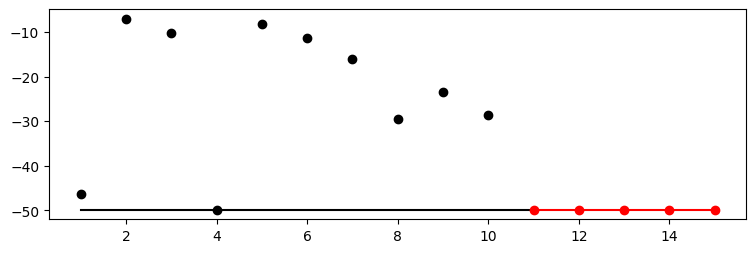

In [24]:
spot_model.plot_progress()

# tuning design table with importances

In [25]:
print(gen_design_table(fun_control=fun_control, spot=spot_model))


| name               | type   | default   |   lower |   upper |                tuned | transform   |   importance | stars   |
|--------------------|--------|-----------|---------|---------|----------------------|-------------|--------------|---------|
| activation_default | factor | clamped   |     0.0 |     3.0 |                  0.0 | None        |        29.60 | *       |
| bias_mutate_power  | float  | 0.5       |     0.1 |     2.0 |   1.1203113611279607 | None        |         8.20 | *       |
| bias_replace_rate  | float  | 0.1       |     0.0 |     1.0 | 0.007259274147483297 | None        |         0.13 | .       |
| conn_add_prob      | float  | 0.2       |     0.0 |     1.0 |    0.776809181139358 | None        |       100.00 | ***     |
| conn_delete_prob   | float  | 0.2       |     0.0 |     1.0 |  0.02008748713799171 | None        |        18.97 | *       |
| node_add_prob      | float  | 0.2       |     0.1 |     1.0 |  0.32336514668325567 | None        |         0.00 |   

P.S. it's interesting that conn_add_prob has the highest importance, when we add consider different activation functions. before node_add_prob was the most important hyperparameter (node_delete_prob the 2nd and conn_add_prob the 3rd).